# Virgo: exploratory data analysis

## Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
import datetime
from dateutil.relativedelta import relativedelta

## Transfomations

visualising stock data

In [4]:
def viz_data(stock_code, n_days, window, lags, plot = True, end_result = False):
    today = datetime.date.today()
    begin_date = today - relativedelta(days = n_days)
    begin_date_str = begin_date.strftime('%Y-%m-%d')

    stock = yf.Ticker(stock_code)
    df = stock.history(period="max")
    df = df.sort_values('Date')
    df.reset_index(inplace=True)

    ### getting rolling mean
    df["Close_roll_mean"] = (
        df.sort_values("Date")["Close"]
        .transform(lambda x: x.rolling(window, min_periods=1).mean())
    )

    ### getting rolling stdv
    df["Close_roll_std"] = (
        df.sort_values("Date")["Close"]
        .transform(lambda x: x.rolling(window, min_periods=1).std())
    )
    df["upper"] = df['Close_roll_mean'] + df["Close_roll_std"]*2
    df["lower"] = df['Close_roll_mean'] - df["Close_roll_std"]*2

    ### differencial analysis
    df['lag'] = df.Close.shift(lags)
    df['Dif'] = np.log(df['Close']) - np.log(df['lag'])
    df['Pos'] = np.where(df['Dif'] >= 0,df['Dif'], np.nan )
    df['Neg'] = np.where(df['Dif'] < 0,df['Dif'], np.nan )

    df = df[df.Date >= begin_date_str ]

    ### Plots
    if plot:
        fig = make_subplots(rows=2, cols=2,vertical_spacing = 0.1,shared_xaxes=True,
                           subplot_titles=(
                               f'stock: {stock_code} roll window analysis: {window} days', 
                                f'log return: {stock_code}, {n_days} days daily returns days',
                                f'stock: {stock_code} differencial: {lags} lags',
                                f'log return: {stock_code}, 14 days daily returns days')
                           )

        fig.add_trace(go.Scatter(x=df['Date'], y=df.Close, marker_color = 'blue', name='Price'),row=1, col=1)
        fig.add_trace(go.Scatter(x=df['Date'], y=df.Close_roll_mean, marker_color = 'grey', name='roll mean' ),row=1, col=1)
        fig.add_trace(go.Scatter(x=df['Date'], y=df.lower, marker_color = 'pink', name='bound' ),row=1, col=1)
        fig.add_trace(go.Scatter(x=df['Date'], y=df.upper, marker_color = 'pink', name='bound', showlegend=False ),row=1, col=1)

        fig.add_trace(go.Bar(x=df['Date'], y=df.Pos, marker_color = 'blue', showlegend=False ),row=2, col=1)
        fig.add_trace(go.Bar(x=df['Date'], y=df.Neg, marker_color = 'red', showlegend=False ),row=2, col=1)

        begin_date_week = today - relativedelta(days = 14)
        begin_date_week_str = begin_date_week.strftime('%Y-%m-%d')

        fig.add_trace(go.Histogram(x=df['Dif'], marker_color = 'blue', showlegend=False, nbinsx = 50 ),row=1, col=2)
        fig.add_trace(go.Histogram(x=df[df.Date >=  begin_date_week_str]['Dif'], marker_color = 'blue', showlegend=False, nbinsx = 20 ),row=2, col=2)

        fig.update_layout(height=900, width=1400, title_text=f"stock {stock_code} vizualization")
        fig.show()
    if end_result:
        return df

In [5]:
n_days = 700
window = 7
lags = 3

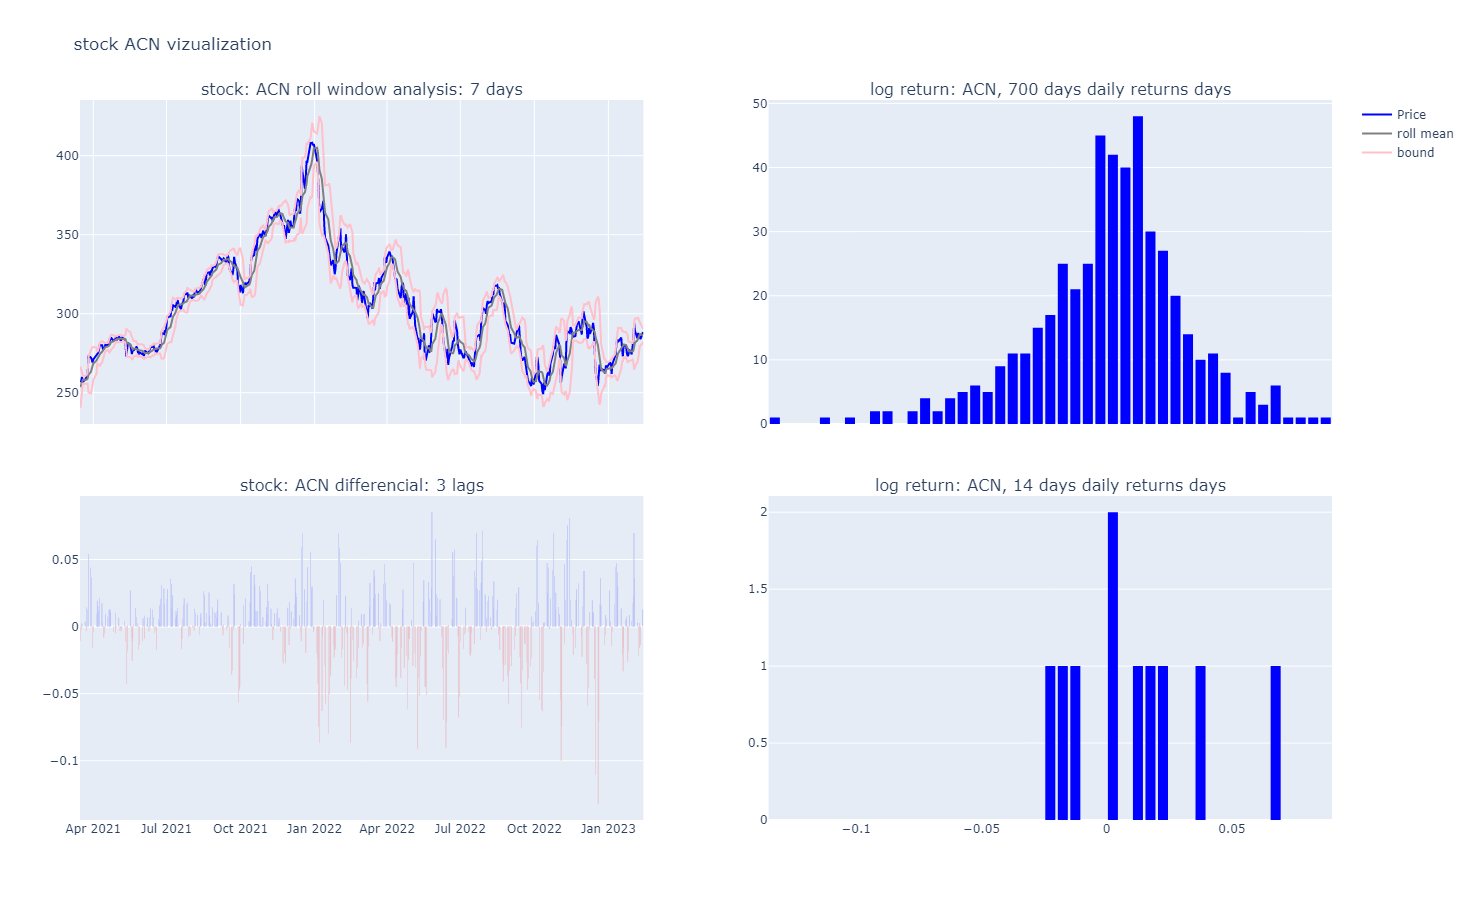

In [16]:
viz_data(stock_code = "ACN", n_days = n_days, window = window, lags = lags)

In [13]:
stocks_codes_ = ['BHP', 'AMGN', 'CVS', 'TLS', 'VOD', 'ALB', 'OCPNY', 'WRK', 'GOOGL','TSLA','BABA', 'ROG','NVO','PFE', 'ACN' ]

In [18]:
def shape_data(data, prefix, ref_price, std_column, logdif_column):
    data = data[['Date', ref_price, std_column, logdif_column]]
    data = data.rename(columns = {
        ref_price: f'{prefix}_price',
        std_column: f'{prefix}_stv',
        logdif_column: f'{prefix}_logdif',
    })
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d',utc=True)
    data['Date'] = pd.to_datetime(data['Date']).dt.date

    return data

In [19]:
std_column = 'Close_roll_std'
ref_price = 'Close'
logdif_column = 'Dif'

In [20]:
data_collection = {}

for code in stocks_codes_:
    df = viz_data(stock_code = code, n_days = n_days, window = window, lags = lags, plot = False, end_result = True)
    df = shape_data(df, code, ref_price, std_column, logdif_column)
    data_collection[code] = df

In [21]:
def merge_data(data_collection, type_merge = 'join'):
    
    if type_merge == 'join':
        
        df_i = data_collection[stocks_codes_[0]]
        for i in stocks_codes_[1:]:
            df_i = df_i.merge(data_collection[i], on = 'Date', how = 'outer')
        analysis_dataset = df_i
        
    elif type_merge == 'index':
        df_i = data_collection[stocks_codes_[0]]
        df_i = df_i.sort_values('Date', ascending = False).reset_index(drop = True).reset_index(drop = False).drop(columns = 'Date').rename(columns = {'index':'Date'})
        
        for j in stocks_codes_[1:]:
            df_j = data_collection[j]
            df_j = df_j.sort_values('Date', ascending = False).reset_index(drop = True).reset_index(drop = False).drop(columns = 'Date').rename(columns = {'index':'Date'})
            df_i = df_i.merge(df_j, on = 'Date', how = 'outer')
            
        analysis_dataset = df_i.dropna()
        
    return analysis_dataset

In [22]:
analysis_dataset = merge_data(data_collection, type_merge = 'index')

In [23]:
def data_corr_analysis(data):
    std_columns = [ x for x in data.columns if x.__contains__('_logdif')]
    data = data[ ['Date'] + std_columns]
    data = data.set_index('Date')
    return data

In [24]:
corr_data_base = data_corr_analysis(data = analysis_dataset )

In [25]:
def plot_correlation(data, n_days, type_merge = 'join'):
    
    today = datetime.date.today()
    begin_date = today - relativedelta(days = n_days)
    begin_date_str = begin_date.strftime('%Y-%m-%d')
    
    if type_merge == 'join':
        data = data[data.index >= begin_date]
        result = data.corr()
    elif type_merge == 'index':
        data = data[data.index >= n_days]
        result = data.corr()

    a4_dims = (25.0, 10.0)
    fig, axes = plt.subplots(1,2,figsize=a4_dims)
    sns.heatmap(result , ax = axes[0], annot=True)
    
    begin_date_week = today - relativedelta(days = 7)
    begin_date_week_str = begin_date.strftime('%Y-%m-%d')
    
    if type_merge == 'join':
        data = data[data.index >= begin_date_week]
        result = data.corr()
    elif type_merge == 'index':
        data = data[data.index >= 7]
        result = data.corr()
    
    sns.heatmap(result , ax = axes[1], annot=True)

    #return result

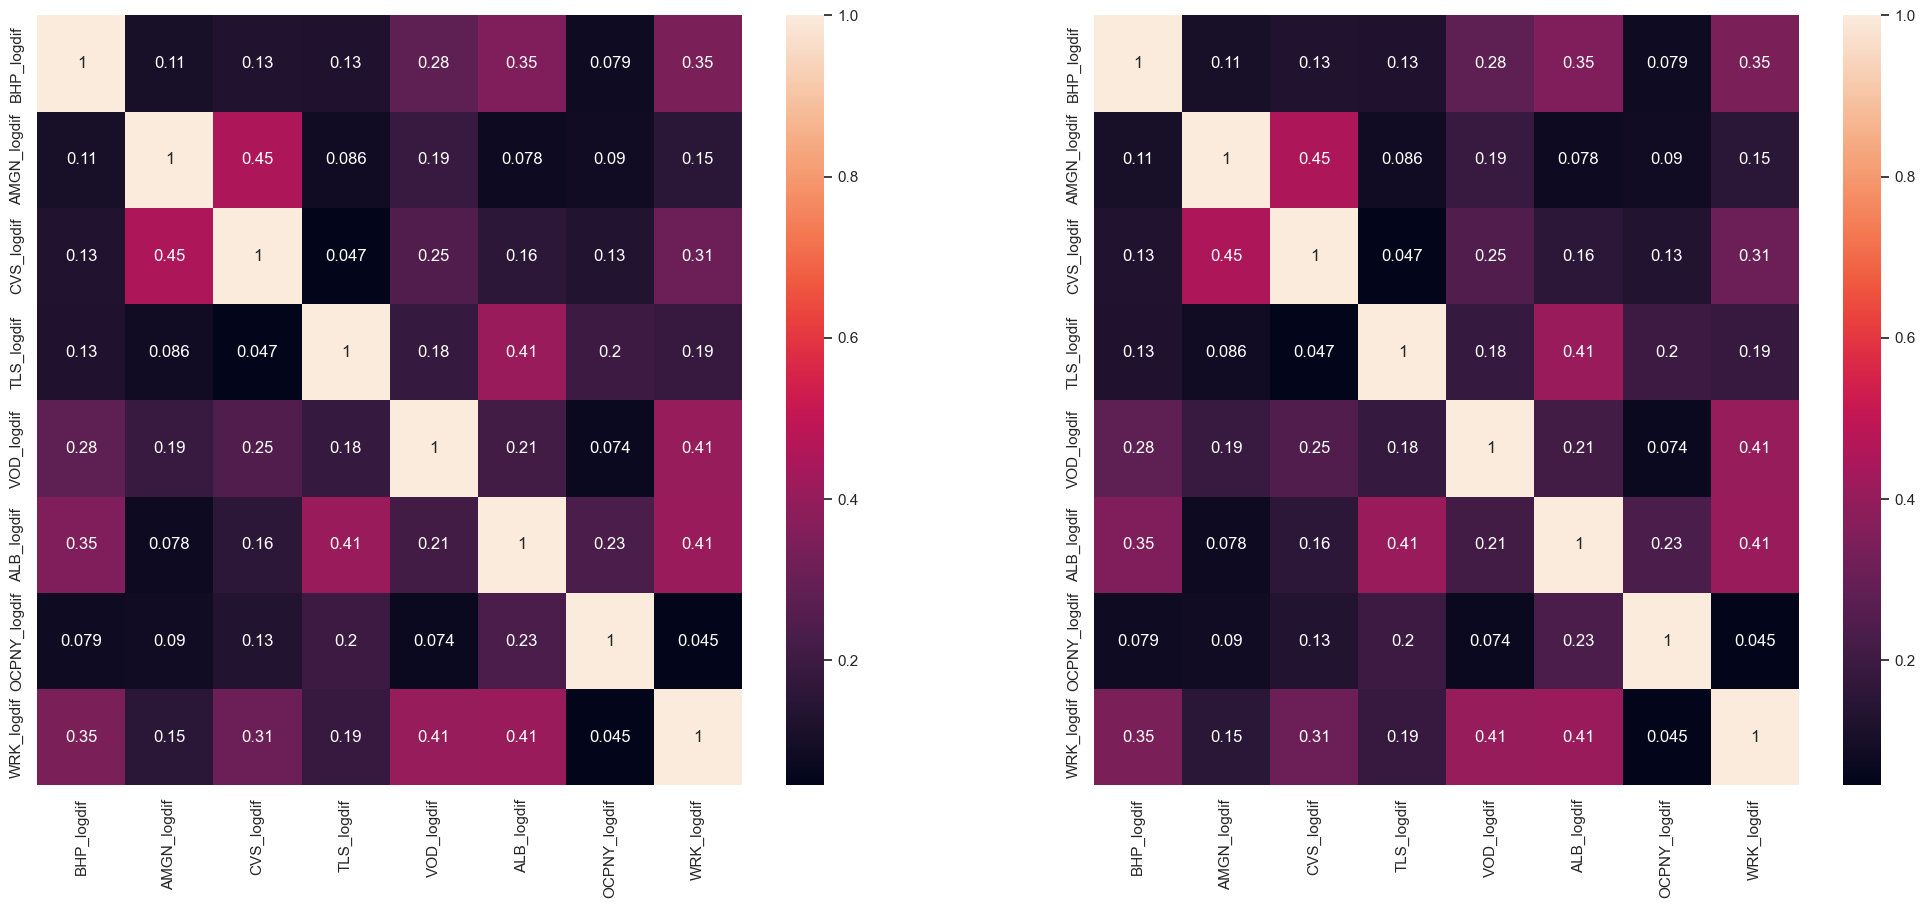

In [26]:
plot_correlation(data = corr_data_base, n_days = 100, type_merge = 'index')